In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

import cv2 


In [2]:
# Define paths
base_dir = 'skin-cancer-mnist-ham10000'
images_part1 = os.path.join(base_dir, '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1')
images_part2 = os.path.join(base_dir, '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2')
metadata_path = os.path.join(base_dir, '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# Load metadata
metadata = pd.read_csv(metadata_path)

# Combine image directories
image_dirs = [images_part1, images_part2]

# Get list of image file paths and labels
image_paths = []
labels = []

for img_dir in image_dirs:
    for img_file in os.listdir(img_dir):
        if img_file.endswith('.jpg') or img_file.endswith('.png'):
            image_paths.append(os.path.join(img_dir, img_file))
            # Extract label from metadata
            img_id = os.path.splitext(img_file)[0]
            label = metadata.loc[metadata['image_id'] == img_id, 'dx'].values[0]
            labels.append(label)

# Convert labels to numerical if needed
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

print(f'Total images: {len(image_paths)}')
print(f'Total classes: {len(le.classes_)}')


Total images: 10015
Total classes: 7


In [3]:
# Parameters
import pandas as pd
IMAGE_SIZE = (32,32) 
BATCH_SIZE = 4
df = pd.DataFrame({'image_path': image_paths, 'label': labels_encoded})

print("Label types before conversion:", df['label'].apply(type).unique())
df['label'] = df['label'].astype(str)

# Confirm conversion
print("Label types after conversion:", df['label'].apply(type).unique())

# Split into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Define ImageDataGenerator for preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)


Label types before conversion: [<class 'int'>]
Label types after conversion: [<class 'str'>]
Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [4]:
def build_mobilenet_unet(input_shape=(64, 64, 3)):
    # Load MobileNetV2 as encoder
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Specify the layers to extract features from
    layer_names = [
        'block_1_expand_relu',   # 112x112
        'block_3_expand_relu',   # 56x56
        'block_6_expand_relu',   # 28x28
        'block_13_expand_relu',  # 14x14
        'block_16_project',      # 7x7
    ]
    layers_output = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extractor model
    feature_extractor = Model(inputs=base_model.input, outputs=layers_output)

    return feature_extractor

# Instantiate the model
feature_extractor = build_mobilenet_unet(input_shape=(*IMAGE_SIZE, 3))
feature_extractor.summary()


/tmp/ipykernel_20368/488309265.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 1,841,984 (7.03 MB)

 Trainable params: 1,811,072 (6.91 MB)

 Non-trainable params: 30,912 (120.75 KB)

In [5]:
# Function to extract features
def extract_features(generator, model, steps):
    features = []
    labels = []
    for i in range(steps):
        x, y = next(generator)
        feat = model.predict(x)
        flattened_feat = [f.reshape(f.shape[0], -1) for f in feat]
        concatenated = np.concatenate(flattened_feat, axis=1)
        features.append(concatenated)
        labels.append(y)
        if (i+1) % 10 == 0:
            print(f'Extracted features for batch {i+1}/{steps}')
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Determine number of steps
train_steps = train_generator.samples // BATCH_SIZE
val_steps = val_generator.samples // BATCH_SIZE

# Extract features for training and validation sets
train_features, train_labels = extract_features(train_generator, feature_extractor, train_steps)
val_features, val_labels = extract_features(val_generator, feature_extractor, val_steps)

print(f'Train features shape: {train_features.shape}')
print(f'Validation features shape: {val_features.shape}')


I0000 00:00:1731415458.785460   20410 service.cc:145] XLA service 0x7c00cc0022d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731415458.785527   20410 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


I0000 00:00:1731415460.672323   20410 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Extracted features for batch 10/2003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Extracted features for batch 20/2003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

In [6]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout

def build_autoencoder(input_dim, encoding_dim=128):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(512, activation='relu')(input_layer)
    encoder = Dropout(0.2)(encoder)
    encoder = Dense(256, activation='relu')(encoder)
    encoder = Dropout(0.2)(encoder)
    encoded = Dense(encoding_dim, activation='relu')(encoder)

    # Decoder
    decoder = Dense(256, activation='relu')(encoded)
    decoder = Dropout(0.2)(decoder)
    decoder = Dense(512, activation='relu')(decoder)
    decoder = Dropout(0.2)(decoder)
    decoded = Dense(input_dim, activation='sigmoid')(decoder)

    # Autoencoder
    autoencoder = Model(inputs=input_layer, outputs=decoded)

    # Encoder model
    encoder_model = Model(inputs=input_layer, outputs=encoded)

    return autoencoder, encoder_model

# Define input dimension based on extracted features
input_dim = train_features.shape[1]

# Build autoencoder
autoencoder, encoder_model = build_autoencoder(input_dim=input_dim, encoding_dim=128)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 39488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    20,218,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 39488)          │    20,257,344 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,804,544 (155.66 MB)

 Trainable params: 40,804,544 (155.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.9652 - val_loss: 2.4350
Epoch 2/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9738 - val_loss: 2.4350
Epoch 3/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9753 - val_loss: 2.4351
Epoch 4/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9756 - val_loss: 2.4351
Epoch 5/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9646 - val_loss: 2.4352
Epoch 6/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9700 - val_loss: 2.4352
Epoch 7/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9648 - val_loss: 2.4352
Epoch 8/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9807 - val_loss: 2.4352
Epoch 9/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9657 - val_loss: 2.4352
Epoch 10/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9750 - val_loss: 2.4352
Epoch 11/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9632 - val_loss: 2.4352
Epoch 12/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/st

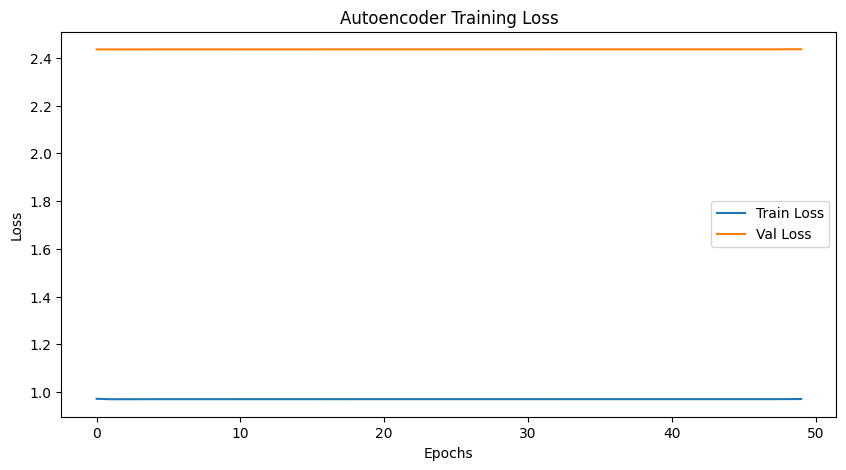

In [7]:
# Normalize features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)

# Train the autoencoder
history = autoencoder.fit(
    train_features_scaled,
    train_features_scaled,
    epochs=50,
    batch_size=16,
    shuffle=True,
    validation_data=(val_features_scaled, val_features_scaled)
)

# Plot training history
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **TSNE for visualization**

Reducing dimensionality using TSNE...


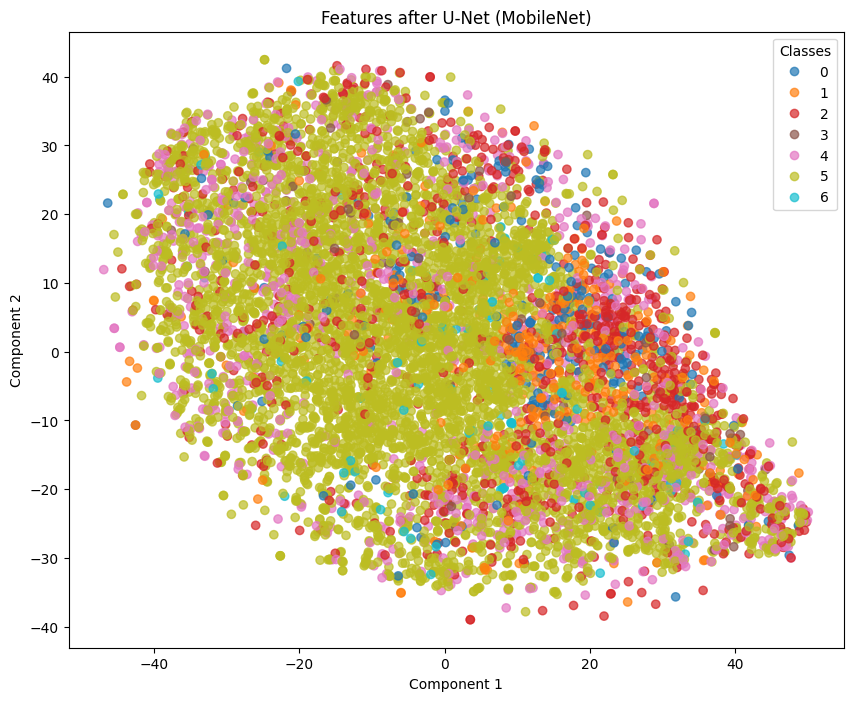

In [9]:
# For visualization, reduce dimensionality using PCA or t-SNE
def visualize_features(features, labels, title='Feature Visualization', method='tsne'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    print(f'Reducing dimensionality using {method.upper()}...')
    reduced_features = reducer.fit_transform(features)
    
    plt.figure(figsize=(10,8))
    scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=labels, cmap='tab10', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Visualize training features
visualize_features(train_features_scaled, train_labels, title='Features after U-Net (MobileNet)', method='tsne')


251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Encoded train features shape: (8012, 128)
Reducing dimensionality using TSNE...


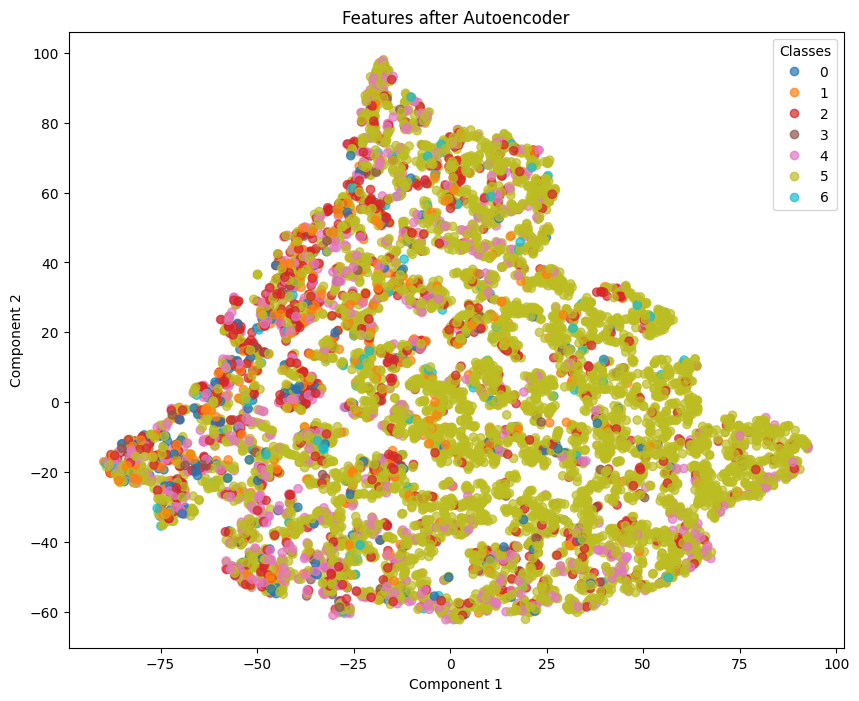

In [10]:
# Encode features using the encoder part of the autoencoder
encoded_train_features = encoder_model.predict(train_features_scaled)
encoded_val_features = encoder_model.predict(val_features_scaled)

print(f'Encoded train features shape: {encoded_train_features.shape}')

# Visualize encoded features
visualize_features(encoded_train_features, train_labels, title='Features after Autoencoder', method='tsne')


Reducing dimensionality using TSNE...


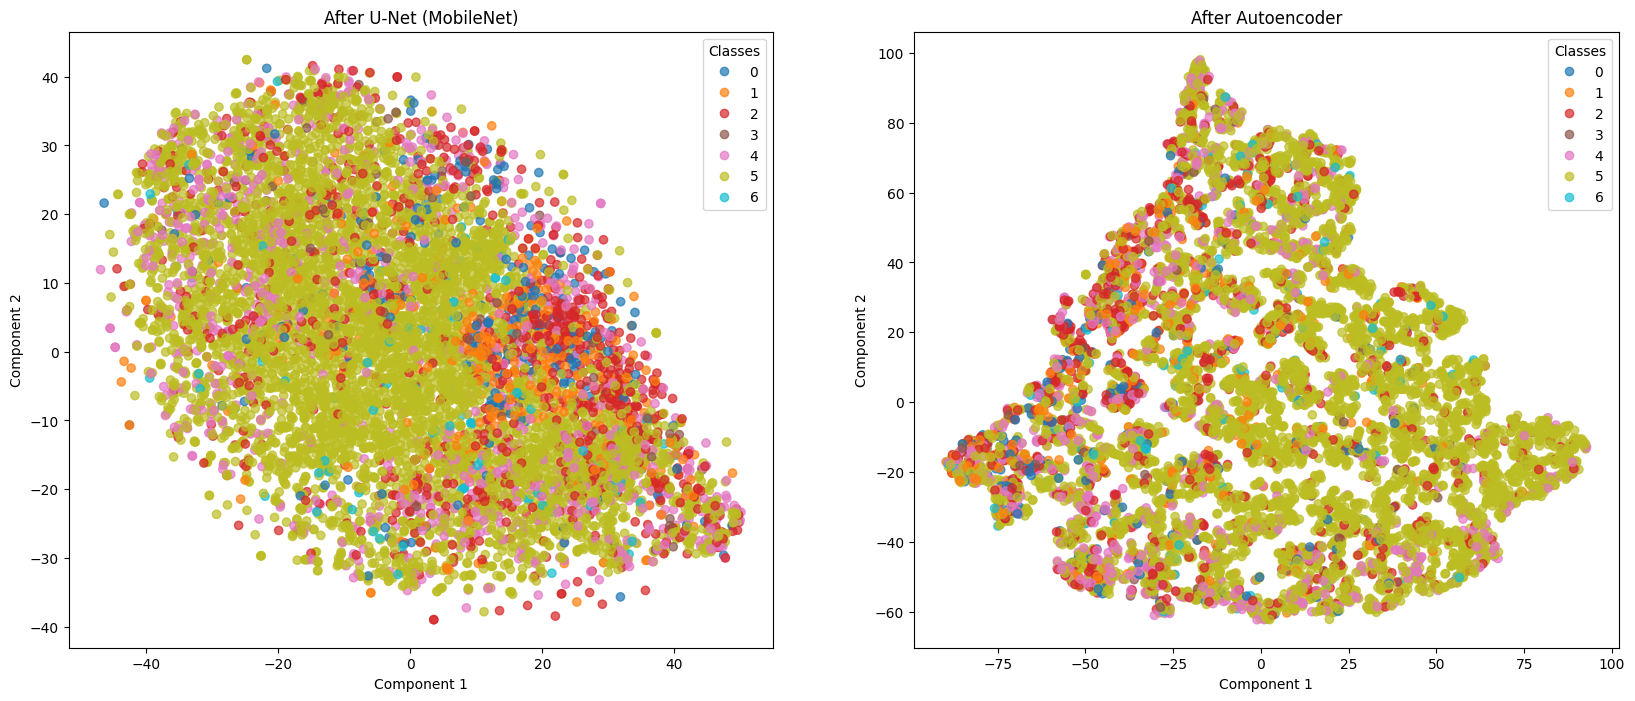

In [11]:
def visualize_side_by_side(features1, labels1, features2, labels2, title1='Feature Set 1', title2='Feature Set 2', method='tsne'):
    if method == 'pca':
        reducer1 = PCA(n_components=2)
        reducer2 = PCA(n_components=2)
    elif method == 'tsne':
        reducer1 = TSNE(n_components=2, random_state=42)
        reducer2 = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    print(f'Reducing dimensionality using {method.upper()}...')
    reduced_features1 = reducer1.fit_transform(features1)
    reduced_features2 = reducer2.fit_transform(features2)
    
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    scatter1 = plt.scatter(reduced_features1[:,0], reduced_features1[:,1], c=labels1, cmap='tab10', alpha=0.7)
    plt.legend(*scatter1.legend_elements(), title="Classes")
    plt.title(title1)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    plt.subplot(1,2,2)
    scatter2 = plt.scatter(reduced_features2[:,0], reduced_features2[:,1], c=labels2, cmap='tab10', alpha=0.7)
    plt.legend(*scatter2.legend_elements(), title="Classes")
    plt.title(title2)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    plt.show()

# Visualize side by side
visualize_side_by_side(train_features_scaled, train_labels, encoded_train_features, train_labels, 
                       title1='After U-Net (MobileNet)', title2='After Autoencoder', method='tsne')


Reducing dimensionality using TSNE...


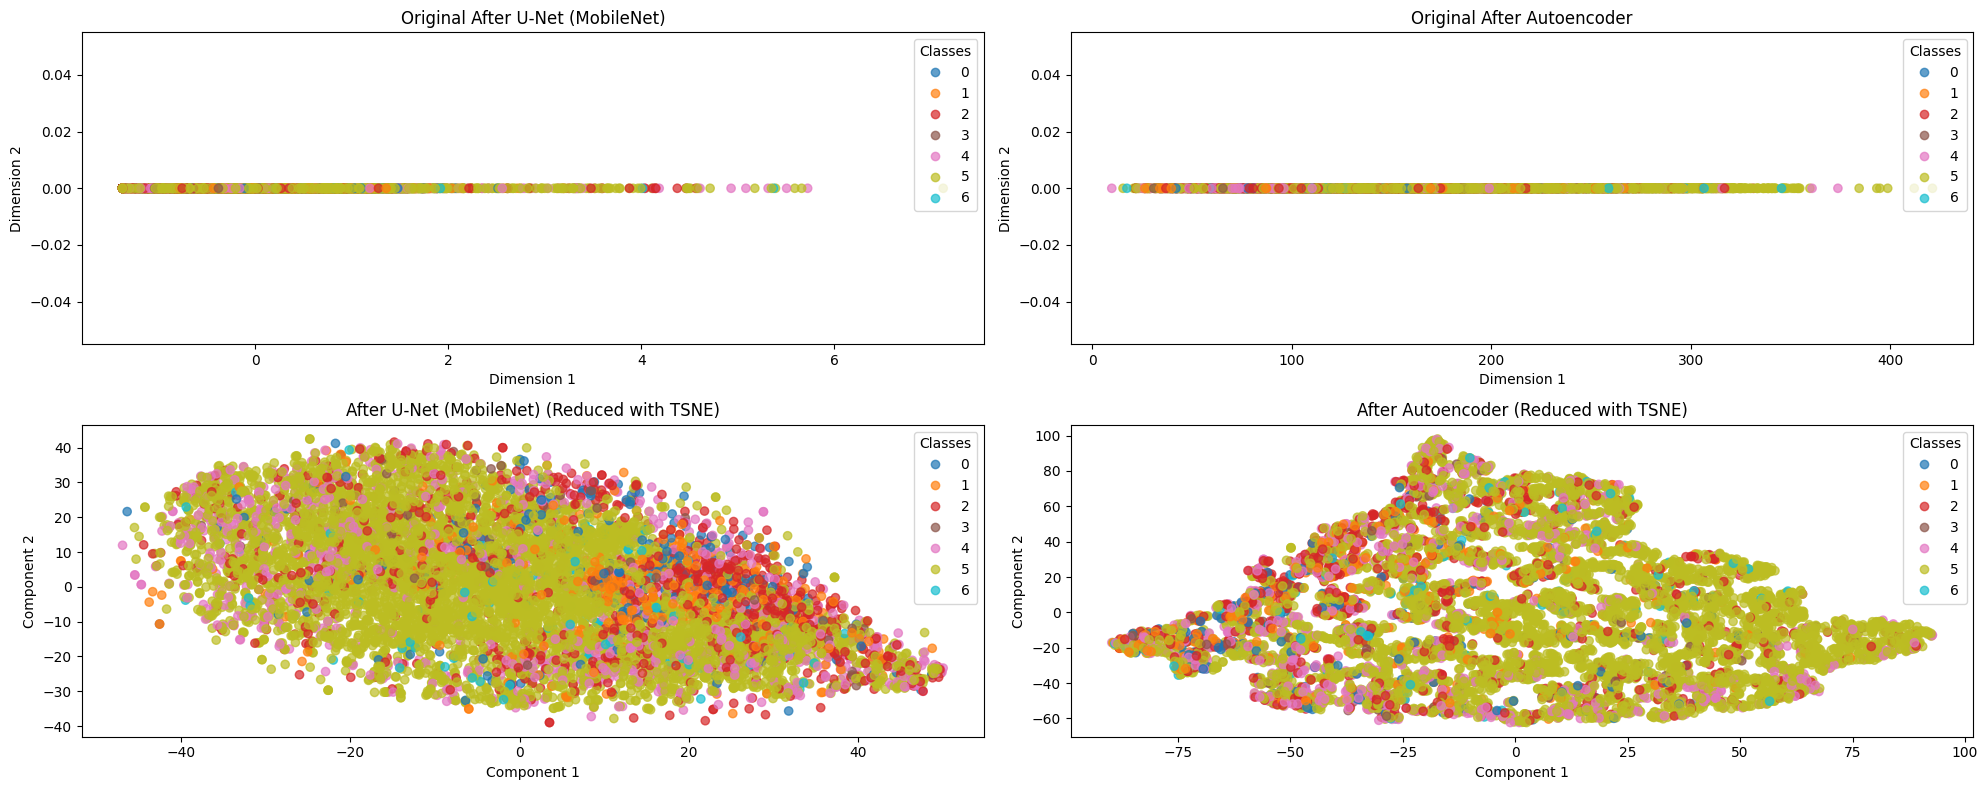

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_side_by_side(features1, labels1, features2, labels2, title1='Feature Set 1', title2='Feature Set 2', method='tsne'):
    # Plot the original high-dimensional features (first 2 dimensions as an approximation)
    plt.figure(figsize=(20, 8))
    
    # Original Feature Set 1
    plt.subplot(2, 2, 1)
    scatter1_original = plt.scatter(features1[:, 0], features1[:, 1], c=labels1, cmap='tab10', alpha=0.7)
    plt.legend(*scatter1_original.legend_elements(), title="Classes")
    plt.title(f'Original {title1}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    # Original Feature Set 2
    plt.subplot(2, 2, 2)
    scatter2_original = plt.scatter(features2[:, 0], features2[:, 1], c=labels2, cmap='tab10', alpha=0.7)
    plt.legend(*scatter2_original.legend_elements(), title="Classes")
    plt.title(f'Original {title2}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    # Dimensionality reduction
    if method == 'pca':
        reducer1 = PCA(n_components=2)
        reducer2 = PCA(n_components=2)
    elif method == 'tsne':
        reducer1 = TSNE(n_components=2, random_state=42)
        reducer2 = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    print(f'Reducing dimensionality using {method.upper()}...')
    reduced_features1 = reducer1.fit_transform(features1)
    reduced_features2 = reducer2.fit_transform(features2)
    
    # Reduced Feature Set 1
    plt.subplot(2, 2, 3)
    scatter1 = plt.scatter(reduced_features1[:, 0], reduced_features1[:, 1], c=labels1, cmap='tab10', alpha=0.7)
    plt.legend(*scatter1.legend_elements(), title="Classes")
    plt.title(f'{title1} (Reduced with {method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    # Reduced Feature Set 2
    plt.subplot(2, 2, 4)
    scatter2 = plt.scatter(reduced_features2[:, 0], reduced_features2[:, 1], c=labels2, cmap='tab10', alpha=0.7)
    plt.legend(*scatter2.legend_elements(), title="Classes")
    plt.title(f'{title2} (Reduced with {method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    plt.tight_layout()
    plt.show()

# Visualize side by side
visualize_side_by_side(train_features_scaled, train_labels, encoded_train_features, train_labels, 
                       title1='After U-Net (MobileNet)', title2='After Autoencoder', method='tsne')


# PCA for Visualization 

Reducing dimensionality using PCA...


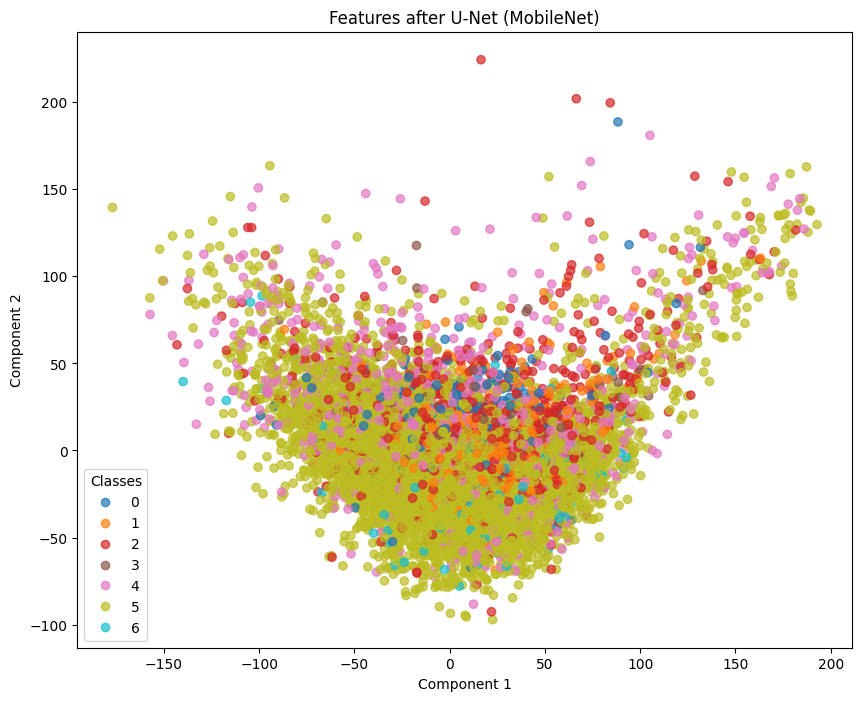

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# For visualization, reduce dimensionality using PCA or t-SNE
def visualize_features(features, labels, title='Feature Visualization', method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    print(f'Reducing dimensionality using {method.upper()}...')
    reduced_features = reducer.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Visualize training features using PCA
visualize_features(train_features_scaled, train_labels, title='Features after U-Net (MobileNet)', method='pca')


Reducing dimensionality using PCA...


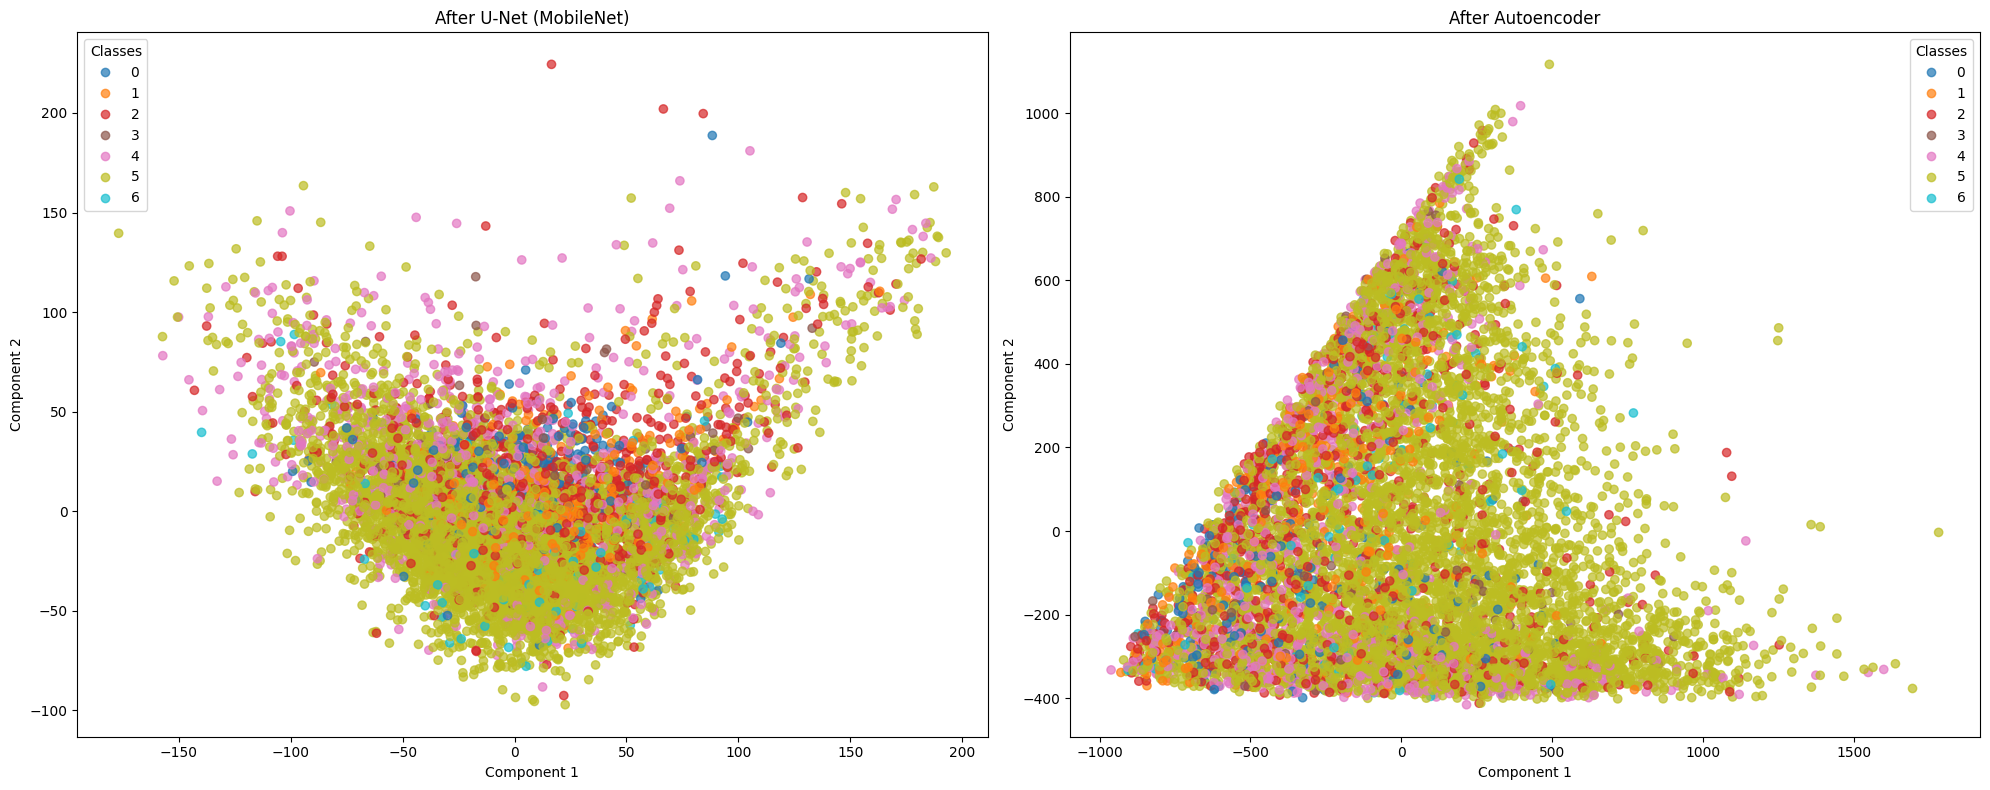

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_side_by_side(features1, labels1, features2, labels2, title1='Feature Set 1', title2='Feature Set 2', method='pca'):
    if method == 'pca':
        reducer1 = PCA(n_components=2)
        reducer2 = PCA(n_components=2)
    elif method == 'tsne':
        reducer1 = TSNE(n_components=2, random_state=42)
        reducer2 = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    print(f'Reducing dimensionality using {method.upper()}...')
    reduced_features1 = reducer1.fit_transform(features1)
    reduced_features2 = reducer2.fit_transform(features2)
    
    plt.figure(figsize=(20, 8))
    
    # Plot Feature Set 1
    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(reduced_features1[:, 0], reduced_features1[:, 1], c=labels1, cmap='tab10', alpha=0.7)
    plt.legend(*scatter1.legend_elements(), title="Classes")
    plt.title(title1)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    # Plot Feature Set 2
    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(reduced_features2[:, 0], reduced_features2[:, 1], c=labels2, cmap='tab10', alpha=0.7)
    plt.legend(*scatter2.legend_elements(), title="Classes")
    plt.title(title2)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    plt.tight_layout()
    plt.show()

# Visualize side by side using PCA
visualize_side_by_side(train_features_scaled, train_labels, encoded_train_features, train_labels, 
                       title1='After U-Net (MobileNet)', title2='After Autoencoder', method='pca')


Reducing dimensionality using PCA...


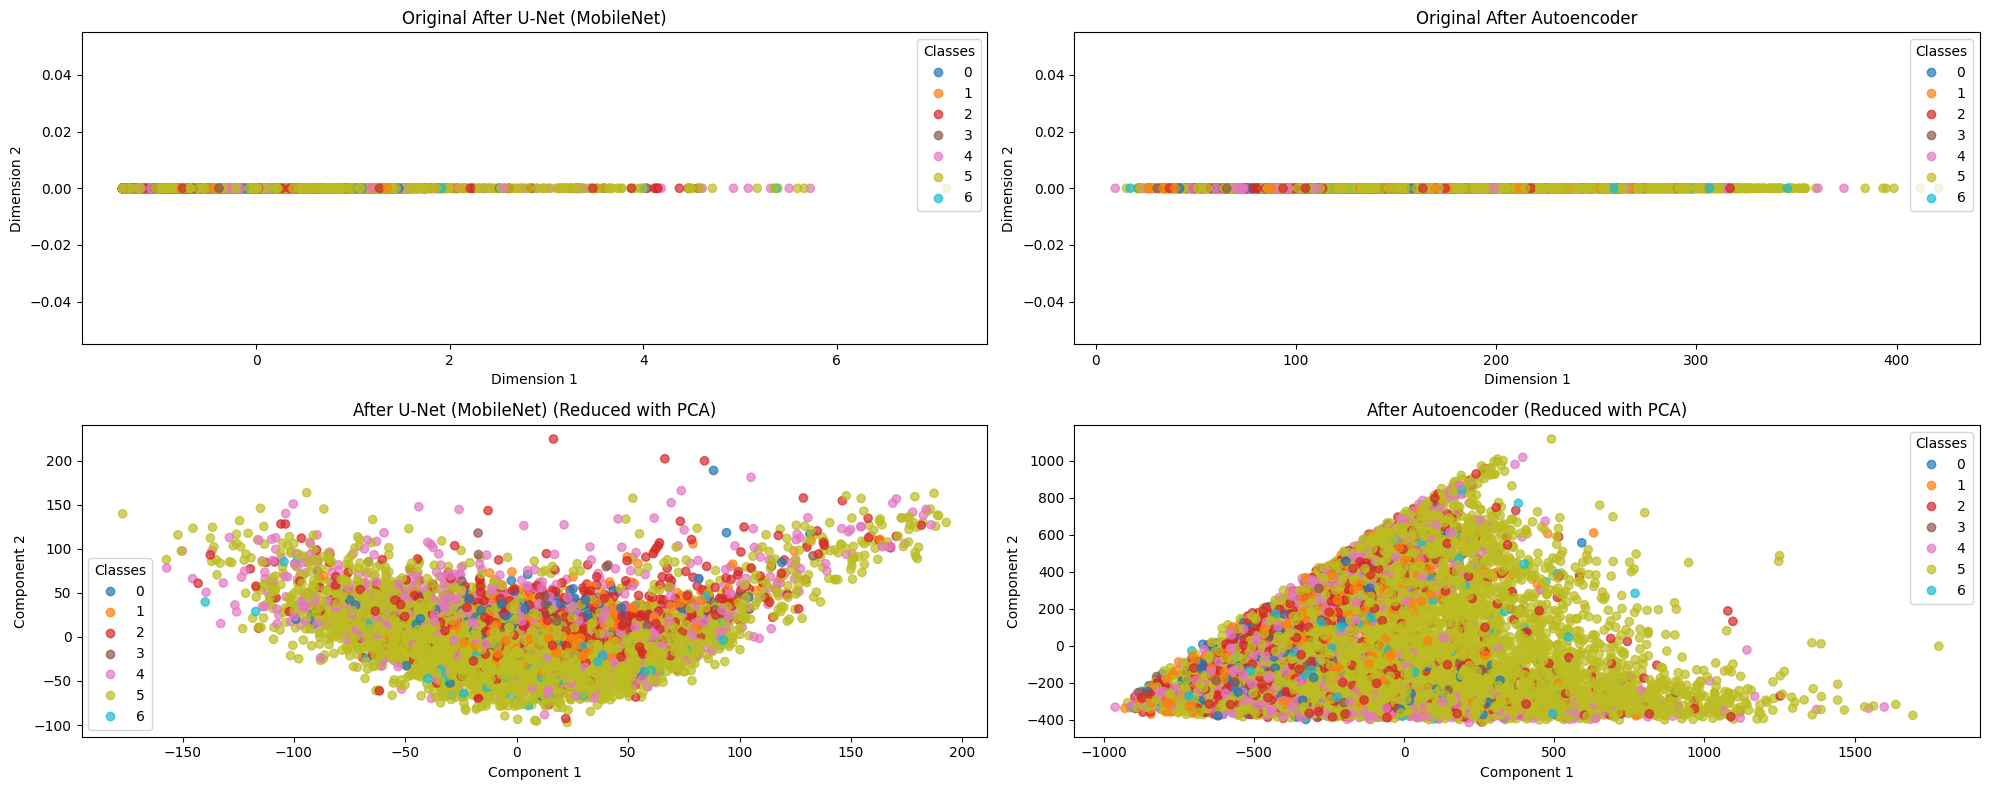

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_side_by_side(features1, labels1, features2, labels2, title1='Feature Set 1', title2='Feature Set 2', method='pca'):
    # Plot the original high-dimensional features (first 2 dimensions as an approximation)
    plt.figure(figsize=(20, 8))
    
    # Original Feature Set 1
    plt.subplot(2, 2, 1)
    scatter1_original = plt.scatter(features1[:, 0], features1[:, 1], c=labels1, cmap='tab10', alpha=0.7)
    plt.legend(*scatter1_original.legend_elements(), title="Classes")
    plt.title(f'Original {title1}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    # Original Feature Set 2
    plt.subplot(2, 2, 2)
    scatter2_original = plt.scatter(features2[:, 0], features2[:, 1], c=labels2, cmap='tab10', alpha=0.7)
    plt.legend(*scatter2_original.legend_elements(), title="Classes")
    plt.title(f'Original {title2}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    # Dimensionality reduction
    if method == 'pca':
        reducer1 = PCA(n_components=2)
        reducer2 = PCA(n_components=2)
    elif method == 'tsne':
        reducer1 = TSNE(n_components=2, random_state=42)
        reducer2 = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    print(f'Reducing dimensionality using {method.upper()}...')
    reduced_features1 = reducer1.fit_transform(features1)
    reduced_features2 = reducer2.fit_transform(features2)
    
    # Reduced Feature Set 1
    plt.subplot(2, 2, 3)
    scatter1 = plt.scatter(reduced_features1[:, 0], reduced_features1[:, 1], c=labels1, cmap='tab10', alpha=0.7)
    plt.legend(*scatter1.legend_elements(), title="Classes")
    plt.title(f'{title1} (Reduced with {method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    # Reduced Feature Set 2
    plt.subplot(2, 2, 4)
    scatter2 = plt.scatter(reduced_features2[:, 0], reduced_features2[:, 1], c=labels2, cmap='tab10', alpha=0.7)
    plt.legend(*scatter2.legend_elements(), title="Classes")
    plt.title(f'{title2} (Reduced with {method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    plt.tight_layout()
    plt.show()

# Visualize side by side using PCA
visualize_side_by_side(train_features_scaled, train_labels, encoded_train_features, train_labels, 
                       title1='After U-Net (MobileNet)', title2='After Autoencoder', method='pca')


PCA v/s T-SNE:

PCA is a linear dimensionality reduction technique. It captures global structure by finding the directions (principal components) that explain the most variance in the data.
t-SNE is a non-linear technique, focused on preserving local structure by positioning similar data points closer together. It’s particularly effective for visualizing clusters.

Conclusion:

PCA shows non scattered points while t-SNE reveals clusters, it indicate that linear relationships alone are not sufficient to capture all the underlying patterns in  data.



